In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.spatial import cKDTree

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore')

%matplotlib inline
sb.set(style="ticks", color_codes=True, context="notebook", font_scale=1.4)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

def MAD(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [3]:
field = 'Blind15A_01'
epoch = '02'

ccds_file = '%s/INFO/ccds.txt' % (mainpath)
ccds = np.loadtxt(ccds_file, comments = '#', dtype = str)
print ccds

['N1' 'N2' 'N3' 'N4' 'N5' 'N6' 'N7' 'N8' 'N9' 'N10' 'N11' 'N12' 'N13' 'N14'
 'N15' 'N16' 'N17' 'N18' 'N19' 'N20' 'N21' 'N22' 'N23' 'N24' 'N25' 'N26'
 'N27' 'N28' 'N29' 'N31' 'S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'S10'
 'S11' 'S12' 'S13' 'S14' 'S15' 'S16' 'S17' 'S18' 'S19' 'S20' 'S21' 'S22'
 'S23' 'S24' 'S25' 'S26' 'S27' 'S28' 'S29' 'S31']


In [5]:
gaia, ps1, hits, hits_scamp = {}, {}, {}, {}
for ccd in ccds:
    print '\r', ccd,
    gaia_path = '%s/GAIA/%s_GAIA_%s.vot' % (mainpath, field, ccd)
    ps1_path = '%s/PanSTARRS/%s_PS1_%s.vot' % (mainpath, field, ccd)
    hits_path = '%s/catalogues/%s/%s_%s_%s_image_crblaster_thresh1.0_minarea1_backsize64_final-scamp.dat' %\
                (mainpath, field, field, ccd, epoch)
    hits_scamp_path = '%s/catalogues/%s/%s_%s_%s_image_crblaster_scamp.dat' %\
                      (mainpath, field, field, ccd, epoch)
    
    gaia[ccd] = Table.read(gaia_path, format='votable').to_pandas()
    ps1[ccd] = Table.read(ps1_path).to_pandas()
    hits[ccd] = pd.read_csv(hits_path, delimiter='\t')
    hits_scamp[ccd] = pd.read_csv(hits_scamp_path, delimiter=' ')

S31                                                          


In [6]:
hits_scamp['N1'].columns

Index([u'SOURCE_NUMBER', u'CATALOG_NUMBER', u'EXTENSION', u'ASTR_INSTRUM',
       u'PHOT_INSTRUM', u'X_IMAGE', u'Y_IMAGE', u'ERRA_IMAGE', u'ERRB_IMAGE',
       u'ERRTHETA_IMAGE', u'ALPHA_J2000', u'DELTA_J2000', u'ERRA_WORLD',
       u'ERRB_WORLD', u'ERRTHETA_WORLD', u'EPOCH', u'MAG', u'MAGERR',
       u'FLAGS_EXTRACTION', u'FLAGS_SCAMP', u'FLAGS_IMA'],
      dtype='object')

In [7]:
ff_ps1_ra, ff_gaia_ra = [], []
scamp_ps1_ra, scamp_gaia_ra = [], []
ff_ps1_dec, ff_gaia_dec = [], []
scamp_ps1_dec, scamp_gaia_dec = [], []
ff_ps1_sep = []
ff_gaia_sep = []
scamp_ps1_sep = []
scamp_gaia_sep = []
for k,ccd in enumerate(ccds):
    
    print 'CCD:',  ccd
    print 'len of HiTS:', len(hits[ccd])
    print 'len of HiTS-SCAMP:', len(hits_scamp[ccd])
    print 'len of ps1:', len(ps1[ccd])
    print 'len of gaia:', len(gaia[ccd])
    
    ##################################################################
    # RaDec sky match between HiTS and PS1
    ##################################################################
    HITS_coord = SkyCoord(ra=hits[ccd]['RA'].values, 
                          dec=hits[ccd]['DEC'].values, 
                          frame='icrs', unit=u.degree)
    SCAMP_coord = SkyCoord(ra=hits_scamp[ccd]['ALPHA_J2000'].values, 
                          dec=hits_scamp[ccd]['DELTA_J2000'].values, 
                          frame='icrs', unit=u.degree)
    
    PS1_coord = SkyCoord(ra=ps1[ccd]['raMean'].values, 
                         dec=ps1[ccd]['decMean'].values,
                         frame='icrs', unit=u.degree)  
    GAIA_coord = SkyCoord(ra=gaia[ccd]['ra'].values, 
                          dec=gaia[ccd]['dec'].values, 
                          frame='icrs', unit=u.degree)
    
    ##################################################################
    ##################################################################
    
    idx, d2d, d3d = HITS_coord.match_to_catalog_3d(SCAMP_coord)
    mask_less = (d2d.arcsec < 1)
    print 'N matches wihitn 1\' (FF-SCAMP):', len(idx[mask_less])
    
    match_HITS = hits[ccd].iloc[mask_less]
    match_scamp  = hits_scamp[ccd].iloc[idx[mask_less]]
    
    #fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))
    #histo, axis = plt.subplots(1,2, sharey=True, figsize=(8,3))
    
    #ax[0,0].axvline(0, c='k', lw=.5)
    #ax[0,0].axhline(0, c='k', lw=.5)
    #ax[0,0].plot((match_HITS['RA'].values-match_scamp['ALPHA_J2000'].values)*3600., 
    #             (match_HITS['DEC'].values-match_scamp['DELTA_J2000'].values)*3600.,
    #             '.b', alpha=.7, ms=5, label='FF-SCAMP')
    #ax[0,0].set_ylabel('DEC (arcsec)')
    #ax[0,0].set_xlim(-.5,.5)
    #ax[0,0].set_ylim(-.5,.5)
    #ax[0,0].legend(loc='best')
    
    ##################################################################
    ##################################################################
    
    idx, d2d, d3d = HITS_coord.match_to_catalog_3d(PS1_coord)
    mask_less = (d2d.arcsec < 1)
    print 'N matches wihitn 1\' (FF-PS1):', len(idx[mask_less])
    
    #axis[0].hist(d2d.arcsec[d2d.arcsec < 5.], bins=50, normed=True,
    #             histtype='step', color='b', lw=2, label='FF-PS1')
    
    match_HITS = hits[ccd].iloc[mask_less]
    match_PS1  = ps1[ccd].iloc[idx[mask_less]]
    
    ff_ps1_ra.extend((match_HITS['RA'].values-match_PS1['raMean'].values)*3600.)
    ff_ps1_dec.extend((match_HITS['DEC'].values-match_PS1['decMean'].values)*3600.)
    ff_ps1_sep.extend(d2d.arcsec)
    
    #ax[1,0].plot((match_HITS['RA'].values-match_PS1['raMean'].values)*3600., 
    #             (match_HITS['DEC'].values-match_PS1['decMean'].values)*3600., 
    #             '*b', alpha=.7, ms=7, label='FF-PS1')
    
    ##################################################################
    
    idx, d2d, d3d = SCAMP_coord.match_to_catalog_3d(PS1_coord)
    mask_less = (d2d.arcsec < 1)
    print 'N matches wihitn 1\' (SCAMP-PS1):', len(idx[mask_less])
    
    #axis[0].hist(d2d.arcsec[d2d.arcsec < 5.], bins=50, normed=True, 
    #             histtype='step', color='r', lw=2, label='SCAMP-PS1')
    #axis[0].legend(loc='best')
    #axis[0].set_xlabel('Match distance (arcsec)')
    
    match_SCAMP = hits_scamp[ccd].iloc[mask_less]
    match_PS1  = ps1[ccd].iloc[idx[mask_less]]
    
    scamp_ps1_ra.extend((match_SCAMP['ALPHA_J2000'].values-match_PS1['raMean'].values)*3600.)
    scamp_ps1_dec.extend((match_SCAMP['DELTA_J2000'].values-match_PS1['decMean'].values)*3600.)
    scamp_ps1_sep.extend(d2d.arcsec)
    
    #ax[1,0].axvline(0, c='k', lw=.5)
    #ax[1,0].axhline(0, c='k', lw=.5)
    #ax[1,0].plot((match_SCAMP['ALPHA_J2000'].values-match_PS1['raMean'].values)*3600., 
    #             (match_SCAMP['DELTA_J2000'].values-match_PS1['decMean'].values)*3600., 
    #             '.r', alpha=.7, ms=5, label='SCAMP-PS1')
    #ax[1,0].set_xlim(-.4,.4)
    #ax[1,0].set_ylim(-.4,.4)
    #ax[1,0].set_xlabel('RA (arcsec)')
    #ax[1,0].set_ylabel('DEC (arcsec)')
    #ax[1,0].legend(loc='best')
    
    ##################################################################
    ##################################################################
    
    idx, d2d, d3d = HITS_coord.match_to_catalog_3d(GAIA_coord)
    mask_less = (d2d.arcsec < 1)
    print 'N matches wihitn 1\' (FF-GAIA):', len(idx[mask_less])
    
    #axis[1].hist(d2d.arcsec[d2d.arcsec < 5.], bins=50, normed=True,
    #             histtype='step', color='b', lw=2, label='FF-GAIA')
    
    match_HITS = hits[ccd].iloc[mask_less]
    match_GAIA = gaia[ccd].iloc[idx[mask_less]]
    
    ff_gaia_ra.extend((match_HITS['RA'].values-match_GAIA['ra'].values)*3600.)
    ff_gaia_dec.extend((match_HITS['DEC'].values-match_GAIA['dec'].values)*3600.)
    ff_gaia_sep .extend(d2d.arcsec)
    
    #ax[1,1].plot((match_HITS['RA'].values-match_GAIA['ra'].values)*3600., 
    #             (match_HITS['DEC'].values-match_GAIA['dec'].values)*3600., 
    #             '*b', alpha=.5, ms=7, label='FF-GAIA')
    
    ##################################################################
    
    idx, d2d, d3d = SCAMP_coord.match_to_catalog_3d(GAIA_coord)
    mask_less = (d2d.arcsec < 1)
    print 'N matches wihitn 1\' (SCAMP-GAIA):', len(idx[mask_less])
    
    #axis[1].hist(d2d.arcsec[d2d.arcsec < 5.], bins=50, normed=True,
    #             histtype='step', color='r', lw=2, label='SCAMP-GAIA')
    #axis[1].legend(loc='best')
    #axis[1].set_xlabel('Match distance (arcsec)')
    
    match_SCAMP = hits_scamp[ccd].iloc[mask_less]
    match_GAIA = gaia[ccd].iloc[idx[mask_less]]
    
    scamp_gaia_ra.extend((match_SCAMP['ALPHA_J2000'].values-match_GAIA['ra'].values)*3600.)
    scamp_gaia_dec.extend((match_SCAMP['DELTA_J2000'].values-match_GAIA['dec'].values)*3600.)
    scamp_gaia_sep.extend(d2d.arcsec)
    
    #ax[1,1].axvline(0, c='k', lw=.5)
    #ax[1,1].axhline(0, c='k', lw=.5)
    #ax[1,1].plot((match_SCAMP['ALPHA_J2000'].values-match_GAIA['ra'].values)*3600., 
    #             (match_SCAMP['DELTA_J2000'].values-match_GAIA['dec'].values)*3600., 
    #             '.r', alpha=.5, ms=4, label='SCAMP-GAIA')
    #ax[1,1].set_xlim(-.4,.4)
    #ax[1,1].set_ylim(-.4,.4)
    #ax[1,1].set_xlabel('RA (arcsec)')
    #ax[1,1].legend(loc='best')
    
    # HITS_tree = cKDTree(hits[ccd][['X_IMAGE', 'Y_IMAGE']].values)
    # match_idx = HITS_tree.query(hits_scamp[ccd][['X_IMAGE', 'Y_IMAGE']].values,
    #                        k = 1, distance_upper_bound= 1)[1]
    # mask_yes = (match_idx != len(hits[ccd]))
    # print 'Number of matches wihitn 1 pix:', len(match_idx[mask_yes])
    # match_HITS_pix = hits[ccd].iloc[match_idx[mask_yes]]
    # match_scamp_pix  = hits_scamp[ccd].iloc[mask_yes]
    # 
    # plt.plot(match_HITS_pix['RA']-match_scamp_pix['ALPHA_J2000'], 
    #          match_HITS_pix['DEC']-match_scamp_pix['DELTA_J2000'], '.b', alpha=.7, ms=5)
    # plt.axvline(0, c='k', lw=.7)
    # plt.axhline(0, c='k', lw=.7)
    # plt.xlabel('RA ff-sacamp')
    # plt.ylabel('DEC ff-sacamp')
    # plt.xlim(-.5,.5)
    # plt.ylim(-.5,.5)
    # plt.show()
    
    # fig.tight_layout()
    # fig.subplots_adjust(hspace=0, wspace=0)
    # histo.tight_layout()
    # histo.subplots_adjust(wspace=0)
    # plt.show()
    
    # break

CCD: N1
len of HiTS: 1659
len of HiTS-SCAMP: 908
len of ps1: 3398
len of gaia: 594
N matches wihitn 1' (FF-SCAMP): 667
N matches wihitn 1' (FF-PS1): 916
N matches wihitn 1' (SCAMP-PS1): 868
N matches wihitn 1' (FF-GAIA): 239
N matches wihitn 1' (SCAMP-GAIA): 467
CCD: N2
len of HiTS: 1644
len of HiTS-SCAMP: 846
len of ps1: 2939
len of gaia: 560
N matches wihitn 1' (FF-SCAMP): 644
N matches wihitn 1' (FF-PS1): 855
N matches wihitn 1' (SCAMP-PS1): 810
N matches wihitn 1' (FF-GAIA): 224
N matches wihitn 1' (SCAMP-GAIA): 420
CCD: N3
len of HiTS: 1569
len of HiTS-SCAMP: 715
len of ps1: 3132
len of gaia: 340
N matches wihitn 1' (FF-SCAMP): 609
N matches wihitn 1' (FF-PS1): 815
N matches wihitn 1' (SCAMP-PS1): 671
N matches wihitn 1' (FF-GAIA): 125
N matches wihitn 1' (SCAMP-GAIA): 219
CCD: N4
len of HiTS: 1633
len of HiTS-SCAMP: 825
len of ps1: 3291
len of gaia: 581
N matches wihitn 1' (FF-SCAMP): 612
N matches wihitn 1' (FF-PS1): 882
N matches wihitn 1' (SCAMP-PS1): 801
N matches wihitn 1' (

N matches wihitn 1' (SCAMP-PS1): 739
N matches wihitn 1' (FF-GAIA): 192
N matches wihitn 1' (SCAMP-GAIA): 361
CCD: S3
len of HiTS: 1630
len of HiTS-SCAMP: 785
len of ps1: 3307
len of gaia: 355
N matches wihitn 1' (FF-SCAMP): 654
N matches wihitn 1' (FF-PS1): 904
N matches wihitn 1' (SCAMP-PS1): 756
N matches wihitn 1' (FF-GAIA): 141
N matches wihitn 1' (SCAMP-GAIA): 268
CCD: S4
len of HiTS: 1715
len of HiTS-SCAMP: 860
len of ps1: 3382
len of gaia: 572
N matches wihitn 1' (FF-SCAMP): 624
N matches wihitn 1' (FF-PS1): 882
N matches wihitn 1' (SCAMP-PS1): 821
N matches wihitn 1' (FF-GAIA): 255
N matches wihitn 1' (SCAMP-GAIA): 476
CCD: S5
len of HiTS: 1672
len of HiTS-SCAMP: 992
len of ps1: 3194
len of gaia: 606
N matches wihitn 1' (FF-SCAMP): 748
N matches wihitn 1' (FF-PS1): 975
N matches wihitn 1' (SCAMP-PS1): 961
N matches wihitn 1' (FF-GAIA): 257
N matches wihitn 1' (SCAMP-GAIA): 495
CCD: S6
len of HiTS: 1659
len of HiTS-SCAMP: 721
len of ps1: 3273
len of gaia: 381
N matches wihitn 1

In [8]:
ff_ps1_sep = np.array(ff_ps1_sep)
ff_gaia_sep = np.array(ff_gaia_sep)
scamp_ps1_sep = np.array(scamp_ps1_sep)
scamp_gaia_sep = np.array(scamp_gaia_sep)
ff_ps1_ra = np.array(ff_ps1_ra)
ff_gaia_ra = np.array(ff_gaia_ra)
scamp_ps1_ra = np.array(scamp_ps1_ra)
scamp_gaia_ra = np.array(scamp_gaia_ra)
ff_ps1_dec = np.array(ff_ps1_dec)
ff_gaia_dec = np.array(ff_gaia_dec)
scamp_ps1_dec = np.array(scamp_ps1_dec)
scamp_gaia_dec = np.array(scamp_gaia_dec)

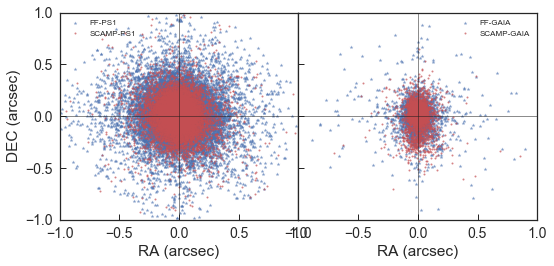

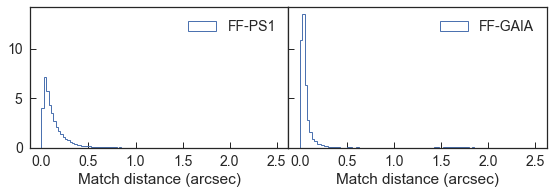

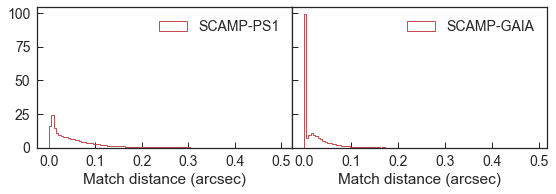

In [9]:
scatt, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
histo, axis = plt.subplots(1,2, sharey=True, figsize=(8,3))
histo2, axis2 = plt.subplots(1,2, sharey=True, figsize=(8,3))

ax[0].plot(ff_ps1_ra, ff_ps1_dec, '*b', alpha=.7, ms=4, label='FF-PS1')
ax[0].plot(scamp_ps1_ra, scamp_ps1_dec, '.r', alpha=.7, ms=4, label='SCAMP-PS1')
ax[0].axvline(0, c='k', lw=.5)
ax[0].axhline(0, c='k', lw=.5)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_xlabel('RA (arcsec)')
ax[0].set_ylabel('DEC (arcsec)')
ax[0].legend(loc='best', fontsize=8)

ax[1].plot(ff_gaia_ra, ff_gaia_dec, '*b', alpha=.7, ms=4, label='FF-GAIA')
ax[1].plot(scamp_gaia_ra, scamp_gaia_dec, '.r', alpha=.7, ms=4, label='SCAMP-GAIA')
ax[1].axvline(0, c='k', lw=.5)
ax[1].axhline(0, c='k', lw=.5)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].set_xlabel('RA (arcsec)')
ax[1].legend(loc='best', fontsize=8)

#######################################################################
axis[0].hist(ff_ps1_sep[ff_ps1_sep < 2.5], bins=100, normed=True,
             histtype='step', color='b', lw=1, label='FF-PS1')
axis2[0].hist(scamp_ps1_sep[scamp_ps1_sep < .5], bins=100, normed=True,
             histtype='step', color='r', lw=1, label='SCAMP-PS1')
axis[0].legend(loc='best')
axis[0].set_xlabel('Match distance (arcsec)')
axis2[0].legend(loc='best')
axis2[0].set_xlabel('Match distance (arcsec)')

axis[1].hist(ff_gaia_sep[ff_gaia_sep < 2.5], bins=100, normed=True,
             histtype='step', color='b', lw=1, label='FF-GAIA')
axis2[1].hist(scamp_gaia_sep[scamp_gaia_sep < .5], bins=100, normed=True,
             histtype='step', color='r', lw=1, label='SCAMP-GAIA')
axis[1].legend(loc='best')
axis[1].set_xlabel('Match distance (arcsec)')
axis2[1].legend(loc='best')
axis2[1].set_xlabel('Match distance (arcsec)')

    
scatt.tight_layout()
scatt.subplots_adjust(wspace=0)
histo.tight_layout()
histo.subplots_adjust(wspace=0)
histo2.tight_layout()
histo2.subplots_adjust(wspace=0)
plt.show()

In [16]:
print scamp_ps1_ra.shape
print scamp_gaia_ra.shape

(45825,)
(23529,)


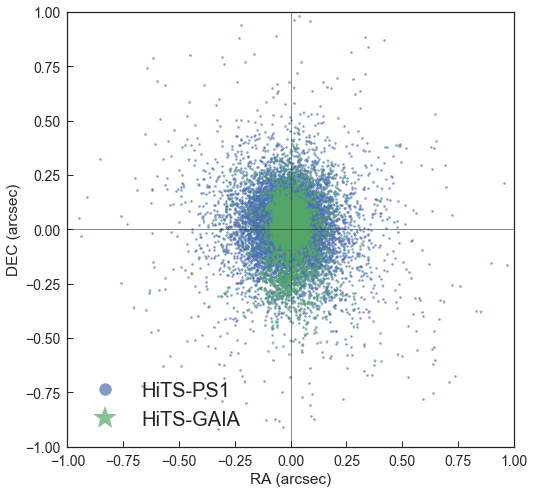

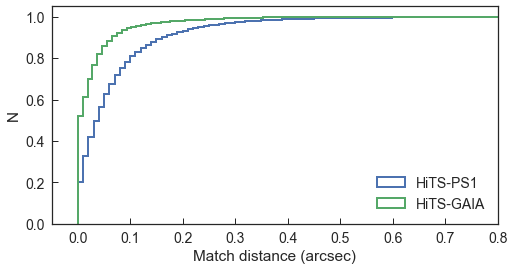

In [13]:
plt.figure(figsize=(8,8))
plt.plot(scamp_ps1_ra, scamp_ps1_dec, '.b', alpha=.7, ms=5, label='HiTS-PS1')
plt.plot(scamp_gaia_ra, scamp_gaia_dec, '*g', alpha=.7, ms=5, label='HiTS-GAIA')
plt.axvline(0, c='k', lw=.5)
plt.axhline(0, c='k', lw=.5)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('RA (arcsec)')
plt.ylabel('DEC (arcsec)')
plt.legend(loc='lower left', fontsize=20, markerscale=5)
plt.savefig('%s/figures/HiTS_astrometry_%s_%s.png' % (mainpath, field, 'scatter'), 
            format='png', dpi=300, bbox_inches='tight')
plt.show()

#######################################################################

plt.figure(figsize=(8,4))
plt.hist(scamp_ps1_sep[scamp_ps1_sep < 1.], bins=100, normed=True,
         cumulative=True, histtype='step', color='b', lw=2,
         label='HiTS-PS1')
plt.hist(scamp_gaia_sep[scamp_gaia_sep < 1.], bins=100, normed=True,
         cumulative=True, histtype='step', color='g', lw=2,
         label='HiTS-GAIA')
#plt.axhline(.99, c='r', lw=1)
plt.xlabel('Match distance (arcsec)')
plt.ylabel('N')
plt.legend(loc='lower right')
plt.xlim(-.05,.8)
plt.savefig('%s/figures/HiTS_astrometry_%s_%s.pdf' % (mainpath, field, 'hist'), 
            format='pdf', dpi=600,bbox_inches='tight')
plt.show()



In [35]:
print 'RMS FF-PS1     (ra, dec): %.3f, %.3f' % (rms(ff_ps1_ra), rms(ff_ps1_dec))
print 'RMS FF-GAIA    (ra, dec): %.3f, %.3f' % (rms(ff_gaia_ra), rms(ff_gaia_dec))
print 'RMS SCAMP-PS1  (ra, dec): %.3f, %.3f' % (rms(scamp_ps1_ra), rms(scamp_ps1_dec))
print 'RMS SCAMP-GAIA (ra, dec): %.3f, %.3f' % (rms(scamp_gaia_ra), rms(scamp_gaia_dec))

RMS FF-PS1     (ra, dec): 0.129, 0.139
RMS FF-GAIA    (ra, dec): 0.065, 0.079
RMS SCAMP-PS1  (ra, dec): 0.073, 0.089
RMS SCAMP-GAIA (ra, dec): 0.029, 0.051


In [34]:
print 'RA  percentil %99 (PS1): ', np.percentile(scamp_ps1_ra, 99)
print 'DEC percentil %99 (PS1): ', np.percentile(scamp_ps1_dec, 99)
print 'RA  percentil %99 (GAIA): ', np.percentile(scamp_gaia_ra, 99)
print 'DEC percentil %99 (GAIA): ', np.percentile(scamp_gaia_dec, 99)

RA  percentil %99 (PS1):  0.220632624001
DEC percentil %99 (PS1):  0.269486058241
RA  percentil %99 (GAIA):  0.082386951537
DEC percentil %99 (GAIA):  0.145211439639
